# House Prices Advanced Regression: My Approach
**By: Brian Rafferty**

Hello! I am a Computer Science graduate student who is emphasising in Data Science courses. My ultimate goal is to have a career analyzing data and creating predictive software, either as a Data Analyst, Data Engineer, or Data Scientist.

That being said, I am still a beginner in the field, and this is my second Kaggle competition I have undertaken. I learned many ways to improve since my first competition, and I have the goal to continue my upward trajectory with mastering the material as I go. If you follow along, my approach will follow this workflow:

## 1. Exploratory Data Analysis
**Understand the data by analyzing statistics and creating detailed visualizations**
* **Big Picture Analysis** - Utilize multivariate statistical analysis to determine the most useful independent variables.
* **Dependent Variable Analysis** - Apply univariate statistical analysis on the dependent variable SalePrice.
* **Determine Correlation** - Directly compare the most useful independent variables with the dependent variable.

## 2. Data Cleaning 
**Prepare the data for the machine learning models**
* **Impute** - Handle missing data and outliers.
* **Encode** - Transform categorical variables into discrete values.
* **Scale** - Normalize continuous numerical variables into a value between 0 and 1.

## 3. Machine Learning
**Determine best estimator to predict SalePrice**
* **Test** - Run the training data through multiple models.
* **Evaluate** - Compare each models' scores to determine strongest estimator.
* **Tune** - Explore optimal hyperparameters with chosen model via k-folds, gradientCV, etc. 
* **Predict** - Run tuned model to predict SalePrice for submission.

In [1]:
# data processing
import numpy as np
import pandas as pd

# exploratory data analysis
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import seaborn as sns

# data cleaning pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler

# machine learning 
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor

# misc settings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in the data and combine it into a single dataframe for future data cleaning
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
y_train = train['SalePrice']
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

train_count = train.shape[0]
test_count = test.shape[0]

# save the Id column for the end
train_ID = train['Id']
test_ID = test['Id']

# drop Id
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

combined = pd.concat((train, test)).reset_index(drop=True)
combined.drop(['SalePrice'], axis=1, inplace=True)
# see all the columns in the dataset
combined.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [3]:
# convert numerical variables that are really categorical
combined['MSSubClass'] = combined['MSSubClass'].apply(str)
combined['OverallCond'] = combined['OverallCond'].astype(str)
combined['YrSold'] = combined['YrSold'].astype(str)
combined['MoSold'] = combined['MoSold'].astype(str)

In [4]:
# get numerical and categorical variables
numerical = combined.select_dtypes(['number']).columns
print(f'\nNumerical: {numerical}')
categorical = combined.columns.difference(numerical)
print(f'\nCategorical: {categorical}')


Numerical: Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

Categorical: Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',


## 1. Exploratory Data Analysis

### Big Picture Analysis
Begin by taking a look at each column to determine its purpose.

According to the documentation, each column can be described as follows:
* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

To test the assumptions based upon descriptions, lets create a graph mapping correlation between each variable and SalePrice.

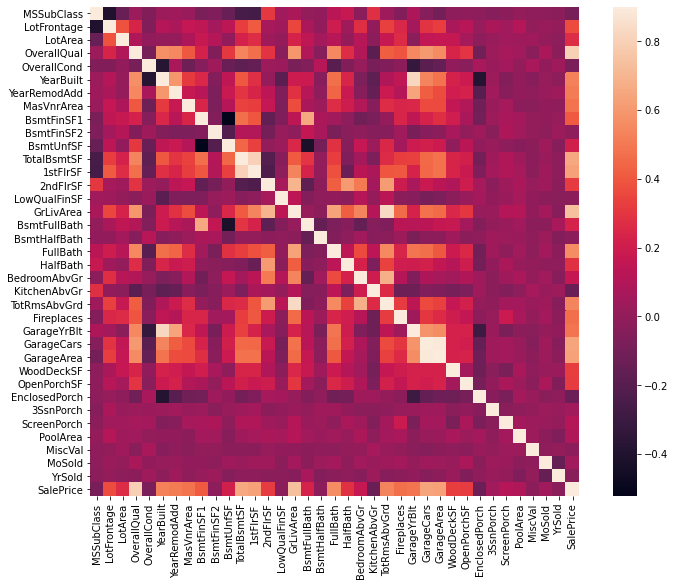

In [5]:
# Create a heatmap to display correlations between each variable
heatmap_corr = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(heatmap_corr, vmax=0.9, square=True)

Looking at the bottom row labeled **SalePrice**, we can see that the independent variables with the highest correlation (brightest color) are:
* OverallQual
* GrLivArea
* GarageCars
* GarageArea
* TotalBsmtSF
* 1stFlrSF
* TotRmsAbvGrd
* FullBath
* YearBuilt

### Dependent Variable Analysis 
Next, we will take a deeper look at the output variable SalePrice.

In [6]:
# look at tabular view of underlying statistics
train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

A trained eye can use this table alone to understand the general makeup of SalePrice, but to the layman it is much more intuitive view a visualization instead. To substantially break things down in terms of the distribution, we will plot a histogram.

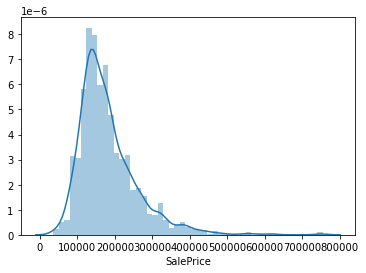

In [7]:
# look at visual representation via a histogram
sns.distplot(train['SalePrice'])

**From the exploratory data analysis we can safely conclude the following about SalePrice:**
* The distribution is right skewed (mean > median)
* The distribution is not normal (SalePrice contains significant outliers)

### Determine Correlation
Let's do some further data analysis by creating visualizations that look at the correlation between the most noteworthy independent variables and SalesPrice.

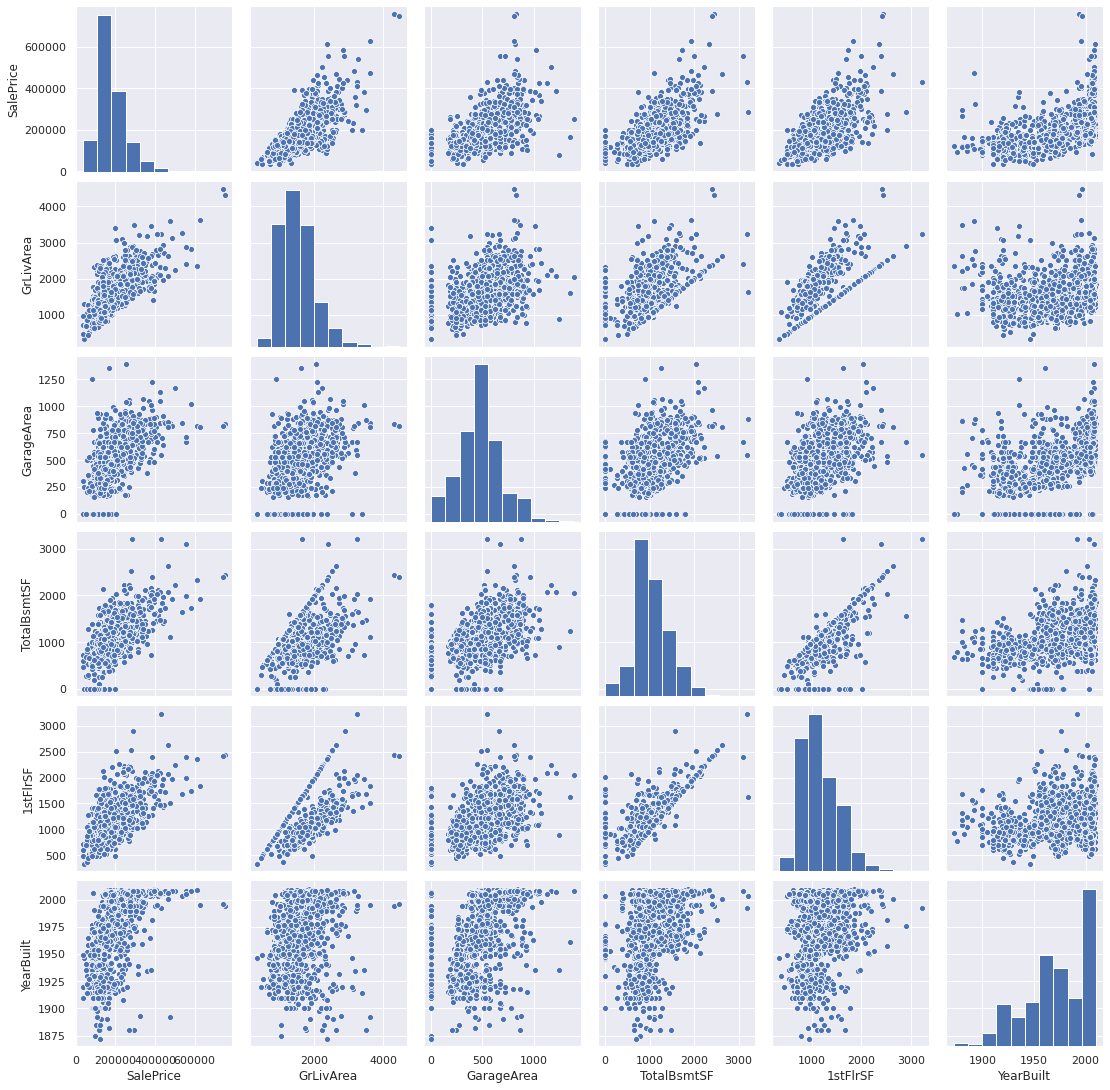

In [8]:
# visualize correlations between the key numeric variables and SalePrice
sns.set()
cols = ['SalePrice', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show()

Looking at the top row, we can see that there is a strong relationship between each numeric independent variable and SalePrice, most are linear and YearBuilt seems to be exponential.

Analyzing numeric variables is easy thanks to pairplot, but now we must create separate box plots for each key categorical variable to determine relationships.

(-0.5, 9.5, 0.0, 800000.0)

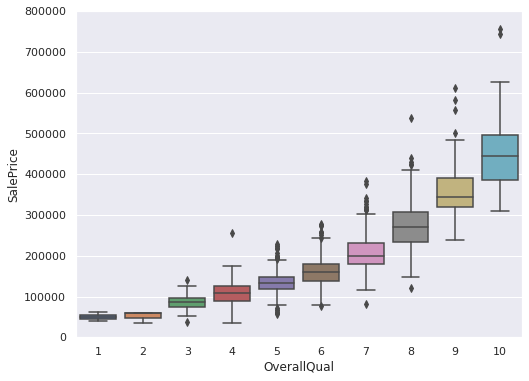

In [9]:
# visualize correlations between OverallQual and SalePrice
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 4.5, 0.0, 800000.0)

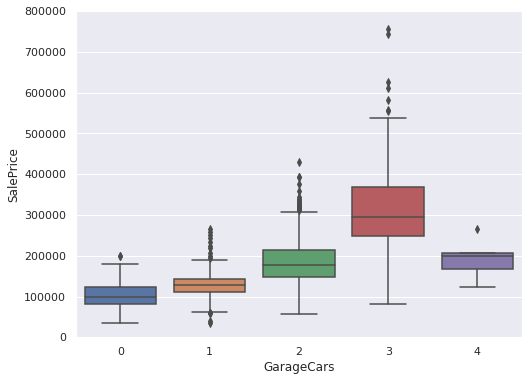

In [10]:
# visualize correlations between GarageCars and SalePrice
data = pd.concat([train['SalePrice'], train['GarageCars']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='GarageCars', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 11.5, 0.0, 800000.0)

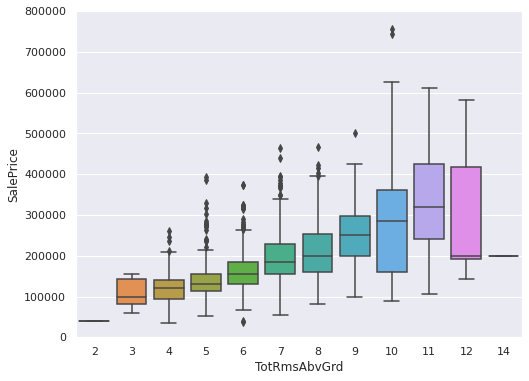

In [11]:
# visualize correlations between TotRmsAbvGrd and SalePrice
data = pd.concat([train['SalePrice'], train['TotRmsAbvGrd']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='TotRmsAbvGrd', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 3.5, 0.0, 800000.0)

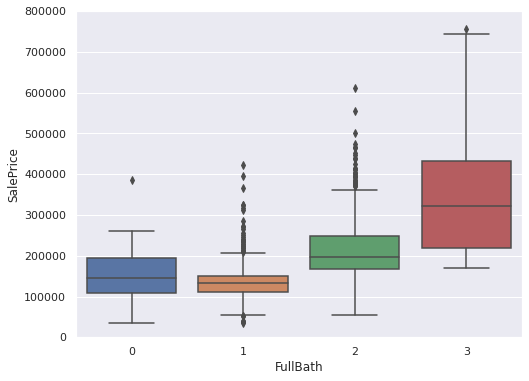

In [12]:
# visualize correlations between FullBath and SalePrice
data = pd.concat([train['SalePrice'], train['FullBath']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='FullBath', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

Strongly linear relationships here as well, box plots are excellent tools to visualize categorical distributions.

## 2. Data Cleaning
Now that we deeply understand the underlying statistics of the dataset from our exploratory data analysis, lets begin cleaning the data for the future machine learning modeling.

Begin by examining which columns have missing data.

In [13]:
# create a table that displays count and percentage of data missing
missing_count = combined.isnull().sum().sort_values(ascending=False)
missing_percentage = (combined.isnull().sum()/combined.isnull().count()).sort_values(ascending=False)
missing = pd.concat([missing_count, missing_percentage], axis=1, keys=['Count', 'Percentage'])
missing.head(40)

,Count,Percentage
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


### Impute, Encode, and Scale
Now we know that we have categorical and numerical variables that need to be cleaned, so lets create a pipeline that imputes, encodes, and scales the combined dataset in parallel. 

In [15]:
# define categorical pipeline
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# define numerical pipeline
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', RobustScaler())])

# combine categorical and numerical pipelines
preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, categorical),
                                               ('num', num_pipe, numerical)])

# fit and transform dataset
preprocessor.fit(combined)
cat = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(categorical)
columns = np.append(cat, numerical)
combined_transformed = pd.DataFrame(preprocessor.transform(combined), columns=columns)
combined_transformed.head()

,Alley_Grvl,Alley_Pave,Alley_missing,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.600,0.0,0.265625,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.075,0.0,-0.078125,1.773810,-0.371429,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.550,0.0,0.500000,0.000000,0.228571,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.475,1.0,0.632812,0.000000,0.128571,272.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.525,1.0,1.390625,1.142857,0.828571,0.0,0.0,0.0,0.0,0.0


## 3. Machine Learning
With the data cleaned, it is now time to determine which model works as the best estimator.

### Test and Evaluate
We will instantiate regressor models, train them, and return their scores.

In [16]:
models = []
models.append(('dum', DummyRegressor(strategy='mean')))
models.append(('ols', LinearRegression()))
models.append(('sgd', SGDRegressor(random_state=8)))
models.append(('etr', ExtraTreesRegressor(random_state=8)))
models.append(('gbm', GradientBoostingRegressor(random_state=8)))
models.append(('rfr', RandomForestRegressor(random_state=8)))
models.append(('svc', SVR()))
models.append(('xgb', XGBRegressor(seed=8)))
models.append(('en', ElasticNet(random_state=8)))
models.append(('las', Lasso(random_state=8)))
models.append(('br', BayesianRidge()))
models.append(('lasl', LassoLarsIC()))

In [17]:
train_transformed = combined_transformed[:train_count]
test_transformed = combined_transformed[train_count:]

# split training data into training set and validation set to test models
X_train, X_validation, Y_train, Y_validation = train_test_split(train_transformed, y_train, test_size=0.2, random_state=1)

In [18]:
for name, model in models:
    '''
    model.fit(train_transformed, y_train)
    score = model.score(train_transformed, y_train)
    print('Accuracy of {} on training set: {}'.format(name, score))
    '''
    model.fit(X_train, Y_train)
    score = model.score(X_validation, Y_validation)
    print('Accuracy of {} on training set: {}'.format(name, score))

Accuracy of dum on training set: -0.0013732548980560644
Accuracy of ols on training set: -1.93496483140426e+16
Accuracy of sgd on training set: -8.590000194044582e+19
Accuracy of etr on training set: 0.897606267771347
Accuracy of gbm on training set: 0.9209812042008071
Accuracy of rfr on training set: 0.8858239205460989
Accuracy of svc on training set: -0.03609126369531879
Accuracy of xgb on training set: 0.8882657419077966
Accuracy of en on training set: 0.8682158633715606
Accuracy of las on training set: 0.9033921153345762
Accuracy of br on training set: 0.9104557163643864
Accuracy of lasl on training set: 0.8909466732840579


### Tune
Explore optimal hyperparameters with chosen model via randomized search CV, which will randomly pick hyperparameters for the model, selecting the best group to use at the end.

In [20]:
# add random hyperparams listed in GBR documentation
loss = ['ls', 'lad', 'huber', 'quantile']
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5]
n_estimators = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'loss': loss}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=8, n_jobs = -1)
# Fit the random search model
gbr_random.fit(X_train, Y_train)

print(gbr_random.best_params_)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = GradientBoostingRegressor(random_state = 8)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_validation, Y_validation)

best_random = gbr_random.best_estimator_
random_accuracy = evaluate(best_random, X_validation, Y_validation)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 31.1min finished


{'n_estimators': 1000, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.05}
Model Performance
Average Error: 15754.6595 degrees.
Accuracy = 89.85%.
Model Performance
Average Error: 14346.2603 degrees.
Accuracy = 90.81%.
Improvement of 1.07%.


### Predict
Finally we can use the tuned model to predict output variables.

In [ ]:
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=3, max_features='auto',
                                   min_samples_leaf=2, min_samples_split=15, 
                                   loss='huber', random_state=8)

model.fit(train_transformed, y_train)
predictions = model.predict(test_transformed)

In [ ]:
submission = pd.DataFrame({'Id': test_ID, 'SalePrice': predictions})

print('Printing Submission CSV')

submission.to_csv('./submission.csv', index=False)

## References
* Luvsandorj, Zolzaya. 'Simple way to find a suitable algorithm for your data in scikit-learn (Python)', https://towardsdatascience.com/simple-way-to-find-a-suitable-algorithm-for-your-data-in-scikit-learn-python-9a9710c7c0fe
* Marcelino, Pedro. 'Comprehensive data exploration with Python', https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
* Serigne. 'Stacked Regressions to predict House Prices', https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/comments